# Demography driven population changes
The MTBC populations we are looking at are going through demographic changes as we observe them. We would expect that:

1. bacterial populations expanded following intial infection, 
2. at the point of diagnosis the patient had a high bacterial load,
3. MTBC load started decreasing upon initiation of treatment,
4. the sequenced population underwent a second expansion _in vitro_ following culture.

We reasoned that performing forward-time population simulations that followed this demographic model would provide a null scenario for our patients.

Start by setting up the kernel

In [1]:
#Python core packages
from collections import Counter
import string
import pickle
import datetime
import warnings
warnings.filterwarnings("ignore")

#Additional Python packages
import tqdm

#Scientific packages
from scipy import stats as ss
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import utils as sku
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
#import simuPOP as sim

mpl.style.use('classic')
mpl.rcParams['font.family']='Arial'
mpl.rcParams['legend.numpoints'] = 1

%matplotlib inline

In [10]:
#DEFINE PATH
REFERENCE_PATH = '../data/external/'
INTERIM_PATH = '../data/interim/'

#FIGURE DETAILS
tick_size = 12
label_size = 14
title_size = 18
text_size = 12
single_column_figure = (3.35,3.35)
double_column_figure_r = (6.69,5)
double_column_figure_s = (6.69,6.69)

## Demographic model

The plan is to use <a href='http://simupop.sourceforge.net/'>simuPOP</a> for forward time simulations. The package takes a generator approach to the demographic model. So need to define it accordingly.

In [3]:
#Define functions
def logistic(x, K, r, N0):
    """Generate a logistic curve

    Input
    -------
    x: 1D array
    K: carrying capacity
    r: Growth rate
    N0: starting population
    
    Output
    -------
    Calculates the population at time x given the parameters using a simple logistic model
    adapted from wikipedia: http://en.wikipedia.org/wiki/Logistic_function 
    
    Notes
    -------
    Made to be used with scipy.optimize.curve_fit 
    """
    return (K*N0*np.exp(r*x))/(K+N0*(np.exp(r*x)-1))

def exp_decay(x, N, k):
    """Calculate the exponential decay of a number.

    Input
    -------
    x: 1D array
    N: Starting population
    k: exponential decay constant

    Output
    -------
    1D array

    Notes
    -------
    Adapted form: http://en.wikipedia.org/wiki/Exponential_decay
    """
    return N*np.exp(-x/k)

def demo_dynamic(g, N0, r, K, k, point_A, point_S, r_=None, K_=None):
    """Demographic function for serial isolates
    
    INPUT:
    ------
    g: number of generations to be conisdered
    N0: starting population (logistic)
    r: growth rate (logistic)
    K: carrying capacity (logistic)
    k: decay rate (exponential decay)
    point_A: generation of effective treatment
    point_S: generation of sampling
    r_: growth rate of re-growth
    K_: carrying capacity of re-growth
    
    OUTPUT:
    -------
    Population size dynamics
    
    NOTES:
    ------
    Modelled on:
    http://simupop.sourceforge.net/manual_release/build/userGuide_ch8_sec2.html
    therefore expected to be called as:
        demo_func = demo_dynamic(101, 100., np.log(2), 100000., 15., 30, 60)
        demo_func(70) : population size at generation 70

    """
    
    if r_==None: r_ = r 
    if K_==None: K_ = K
    
    _unperturbed = logistic(np.arange(g), K, r, N0)
    _decayed = exp_decay(np.arange(g), _unperturbed[point_A], k)
    _regrown = logistic(np.arange(g), K_, r_, _decayed[point_S-point_A]*0.001) #1/1000 dilution
    
    _overall = np.concatenate((_unperturbed[:point_A], _decayed[:point_S-point_A], _regrown))
    
    def snipett(gen):
        return _overall[gen]
    
    return snipett

Now that we've defined the functions to generate the population model, let's have a look at it.

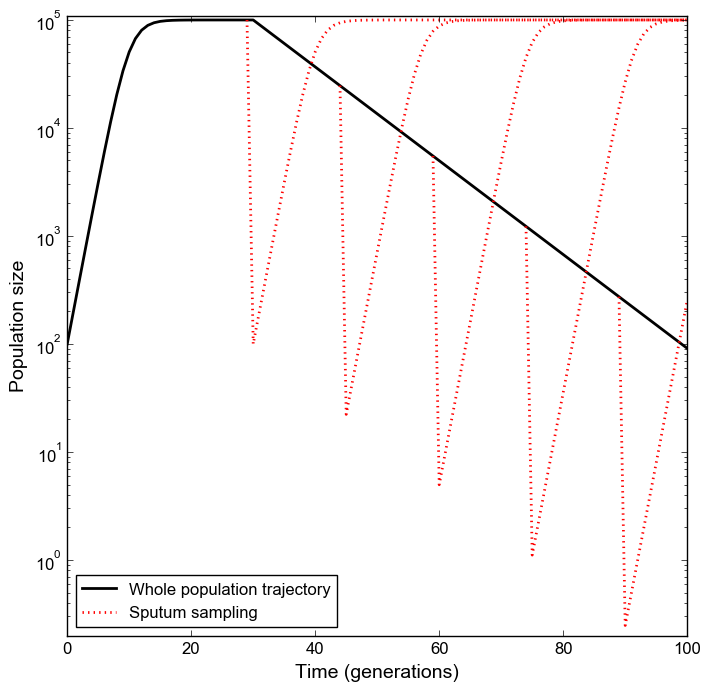

In [4]:
plt.figure('Demographic_model', figsize=(8,8))

demo_func = demo_dynamic(101, 100., np.log(2), 100000., 10., 30, 102) #Have to assume a high enough N0 (rare alleles)
plt.plot(np.arange(101),demo_func(np.arange(101)), 'k-', lw=2)

for sampling in range(30,110,15):
    demo_func = demo_dynamic(101, 100., np.log(2), 100000., 10., 30, sampling) #Have to assume a high enough N0 (rare alleles)
    plt.plot(np.arange(sampling-1,101),
             demo_func(np.arange(sampling-1,101)), 
             'r:', lw=2)


#plt.title('Demographic model',size=title_size)
plt.yticks(size=tick_size)
plt.xticks(np.arange(0,120,20),size=tick_size)
plt.xlim(0,100)
plt.ylim(0.2,110000)
plt.yscale('log')
plt.xlabel('Time (generations)', size=label_size)
plt.ylabel(r'Population size', size=label_size)
plt.legend(['Whole population trajectory', 'Sputum sampling'],loc='lower left',fontsize=tick_size)
#plt.savefig('../reports/figures/7_demographic_model.pdf')

Now that we have the demograhic model we can run the simulations.

In [ ]:
#NOTE THAT THIS OUTCOME WILL BE DIFFERENT EVERY TIME YOU RUN THE SIMULATION
simulation_outcome = {}

#Define sampling rate:
for sampling in tqdm.tqdm([36,48,60,72,84]):
    
    #Define the population
    pop = sim.Population(size=100, loci=1)
    
    #Define the demographic trajectory
    demo_function = demo_dynamic(101, 100., np.log(2), 100000., 10., 30, sampling)

    #Initiate the simulation
    simu = sim.Simulator(pop,rep=100)
    
    #Evolve population
    simu.evolve(
        initOps=[
            sim.InitSex(),
            sim.InitGenotype(freq=[0.95,0.05]), #proportion of minor to major allele
            sim.PyExec('traj=[]') #Initiate a recipient list for frequency outputs
        ],
        matingScheme=sim.RandomSelection(subPopSize=demo_function), #random binary fission
        postOps=[
            sim.Stat(alleleFreq=0),
            sim.PyExec('traj.append(alleleFreq[0][1])', step=10), #record state of the simulation
        ],
        gen=101 #number of generations over which to run the simulation
    )
    
    #Store simulation output
    simulation_outcome[sampling]=[simu.dvars(x).traj[-1] for x in range(100)]

simulation_outcome = pd.DataFrame(simulation_outcome)

simulation_outcome = 

In [5]:
simulation_outcome = pd.read_csv('{}/6_simuPOP_outcome.csv'.format(INTERIM_PATH), index_col=0)

simulation_outcome.head()

,30,45,60,75,90
0,0.050310,0.063691,0.066721,0.000000,0.5
1,0.027345,0.060551,0.253328,0.230132,0.0
2,0.025395,0.029740,0.014680,0.000000,0.0
3,0.037635,0.000000,0.161127,0.292843,0.0
4,0.047840,0.080416,0.188442,0.000000,0.0


Now that we have the simulations, we can calculate two parameters, the first is heterozygosity defined by Cuevas et al for RNA virus pseudostrains:

<strong>Locus heterozigosity</strong>

$h_l = 1 - \sum^{m}_{i=1}f^2_{il}$

<strong>Sample heterozygosity</strong>

$H = \frac{1}{L}\sum^L_{l=1}h_l$

Where $h_l$ is the heterozygosity at locus $l$, $f_{il}$ is the frequency of the $i$-th allele at locus $l$, $m$ is the number of possible alleles (A,C,G,T) and $L$ is the size of the genome. Heterozygosity is calculated for each locus first as shown in Equation above and then calculated for the whole genome as shown in Equation below.

The second metric we calculate is the mean frequency of surviving clones.

In both cases we use bootstraps to get empirical confidence intervals: by performing 1000 bootstraps and using the 25th and 975th permille as limits of the 95% confidence interval.

In [6]:
#The heterozygosity function has been defined in the "serial_functions.py"
%run ../src/data/serial_functions.py

In [27]:
#Load ALLELE data from patients
ALL = pd.read_csv('{}3_ALLELE_data.csv'.format(INTERIM_PATH), index_col=0)

demographic_trends = {'HETEROZYGOSITY': [], 
                      'HET_CI_LOW': [],
                      'HET_CI_HIGH': [], 
                      'FREQUENCY': [], 
                      'FREQ_CI_LOW': [], 
                      'FREQ_CI_HIGH': [], 
                      'X': [], 
                      'SOURCE': []}

#Run bootstraps for population simulations
#heterozygosity
for x in simulation_outcome.columns:
    _temp_het = []
    _temp_freq = []
    for N in range(1000):
        _temp = sku.resample(simulation_outcome[x]) #resample the dataset
        _temp_het.append(heterozygosity(_temp, 4398812))
        _temp_freq.append(np.mean([y for y in _temp if y>0]))
    _temp_het.sort()
    _temp_freq.sort()
    
    demographic_trends['HETEROZYGOSITY'].append(_temp_het[499])
    demographic_trends['HET_CI_LOW'].append(_temp_het[24])
    demographic_trends['HET_CI_HIGH'].append(_temp_het[975])
    demographic_trends['FREQUENCY'].append(_temp_freq[499])
    demographic_trends['FREQ_CI_LOW'].append(_temp_freq[24])
    demographic_trends['FREQ_CI_HIGH'].append(_temp_freq[975])
    demographic_trends['X'].append(x)
    demographic_trends['SOURCE'].append('SIMULATION')

    
for x in [0,2,4,6,8]:
    _temp_het = []
    _temp_freq = []
    for N in range(1000):
        _temp = sku.resample(ALL.FREQUENCY[(ALL.TIME==x)&(ALL.NON_EFFICACIOUS==0)]) #resample the dataset
        _temp_het.append(heterozygosity(_temp, 4398812))
        _temp_freq.append(np.mean([y for y in _temp if y>0]))
    _temp_het.sort()
    _temp_freq.sort()
    
    demographic_trends['HETEROZYGOSITY'].append(_temp_het[499])
    demographic_trends['HET_CI_LOW'].append(_temp_het[24])
    demographic_trends['HET_CI_HIGH'].append(_temp_het[975])
    demographic_trends['FREQUENCY'].append(_temp_freq[499])
    demographic_trends['FREQ_CI_LOW'].append(_temp_freq[24])
    demographic_trends['FREQ_CI_HIGH'].append(_temp_freq[975])
    demographic_trends['X'].append(x)
    demographic_trends['SOURCE'].append('EFFICACIOUS')
    
for x in [0,2,4,6,8]:
    _temp_het = []
    _temp_freq = []
    for N in range(1000):
        _temp = sku.resample(ALL.FREQUENCY[(ALL.TIME==x)&(ALL.NON_EFFICACIOUS==1)]) #resample the dataset
        _temp_het.append(heterozygosity(_temp, 4398812))
        _temp_freq.append(np.mean([y for y in _temp if y>0]))
    _temp_het.sort()
    _temp_freq.sort()
    
    demographic_trends['HETEROZYGOSITY'].append(_temp_het[499])
    demographic_trends['HET_CI_LOW'].append(_temp_het[24])
    demographic_trends['HET_CI_HIGH'].append(_temp_het[975])
    demographic_trends['FREQUENCY'].append(_temp_freq[499])
    demographic_trends['FREQ_CI_LOW'].append(_temp_freq[24])
    demographic_trends['FREQ_CI_HIGH'].append(_temp_freq[975])
    demographic_trends['X'].append(x)
    demographic_trends['SOURCE'].append('NON_EFFICACIOUS')

In [28]:
demographic_trends = pd.DataFrame(demographic_trends)
demographic_trends

,FREQUENCY,FREQ_CI_HIGH,FREQ_CI_LOW,HETEROZYGOSITY,HET_CI_HIGH,HET_CI_LOW,SOURCE,X
0,0.052042,0.058366,0.046116,2.157733e-06,2.413980e-06,1.920157e-06,SIMULATION,30
1,0.060421,0.068531,0.051491,2.130964e-06,2.460789e-06,1.814277e-06,SIMULATION,45
2,0.097280,0.115148,0.080267,2.271505e-06,2.785259e-06,1.762717e-06,SIMULATION,60
3,0.182706,0.220148,0.152418,2.272052e-06,2.903697e-06,1.601166e-06,SIMULATION,75
4,0.541667,0.642857,0.500000,1.136671e-06,1.818673e-06,5.683353e-07,SIMULATION,90
5,0.081433,0.116539,0.058276,1.449157e-06,1.819675e-06,1.124710e-06,EFFICACIOUS,0
6,0.111414,0.164686,0.069218,1.716719e-06,2.222581e-06,1.285993e-06,EFFICACIOUS,2
7,0.142676,0.200906,0.097098,2.157795e-06,2.683924e-06,1.717534e-06,EFFICACIOUS,4
8,0.230041,0.338219,0.129127,1.369420e-06,1.875861e-06,8.950474e-07,EFFICACIOUS,6
9,0.272138,0.475619,0.119025,5.265630e-07,7.708808e-07,3.141590e-07,EFFICACIOUS,8


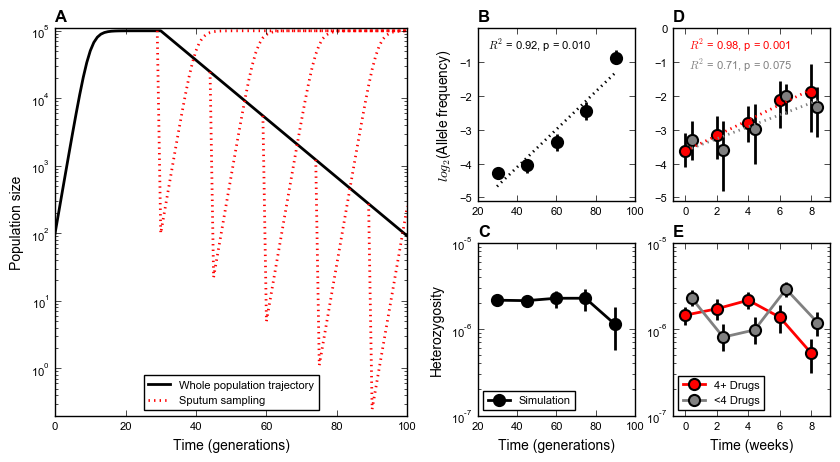

In [65]:
tick_size = 8
label_size = 10
title_size = 12
text_size = 8

plt.figure('demographic', figsize=(10,5))

plt.subplot2grid((11,24), (0,0), rowspan=11, colspan=11) 
#makes a split figure - 11x24 quadrants. The first figure 
#starts in the first column of the 1st row and spans 11 rows and 11 columns.

#Have to assume a high enough N0 (rare alleles)
demo_func = demo_dynamic(101, 100., np.log(2), 100000., 10., 30, 102)
plt.plot(np.arange(101),demo_func(np.arange(101)), 'k-', lw=2)

for sampling in range(30,110,15):
    #Have to assume a high enough N0 (rare alleles)
    demo_func = demo_dynamic(101, 100., np.log(2), 100000., 10., 30, sampling) 
    plt.plot(np.arange(sampling-1,101), demo_func(np.arange(sampling-1,101)), 'r:', lw=2)


#plt.title('Demographic model',size=18)
plt.yticks(size=tick_size)
plt.xticks(np.arange(0,120,20),size=tick_size)
plt.xlim(0,100)
plt.ylim(0.2,110000)
plt.yscale('log')
plt.xlabel('Time (generations)', size=label_size)
plt.ylabel(r'Population size', size=label_size)
plt.legend(['Whole population trajectory', 'Sputum sampling'],loc=8,fontsize=text_size)
plt.title('A',size=title_size, weight='bold',loc='left')

plt.subplot2grid((11,24), (0,13), rowspan=5, colspan=5) 
plt.plot(demographic_trends.X[demographic_trends.SOURCE=='SIMULATION']+.2, 
         np.log2(demographic_trends.FREQUENCY[demographic_trends.SOURCE=='SIMULATION']),
         'o',mec='black',mfc='black',mew=1.5,ms=8)

plt.vlines(demographic_trends.X[demographic_trends.SOURCE=='SIMULATION']+.2,
           np.log2(demographic_trends.FREQ_CI_LOW[demographic_trends.SOURCE=='SIMULATION']), 
           np.log2(demographic_trends.FREQ_CI_HIGH[demographic_trends.SOURCE=='SIMULATION']),
           color='black', lw=2)

s2,i2,r2,p2,e2 = ss.linregress(demographic_trends.X[demographic_trends.SOURCE=='SIMULATION']-.2, 
                               np.log2(demographic_trends.FREQUENCY[demographic_trends.SOURCE=='SIMULATION']))

plt.plot(demographic_trends.X[demographic_trends.SOURCE=='SIMULATION']-.2, 
         (demographic_trends.X[demographic_trends.SOURCE=='SIMULATION']-.2)*s2+i2, 
         ':', color='black', lw=2)

plt.text(25,-0.6,r'$R^2$ = %.2f, p = %.3f' %(r2**2,p2), fontsize=text_size, color='black')
plt.title('B',size=title_size, weight='bold',loc='left')
plt.yticks(np.arange(-6,0,1),size=tick_size)
plt.xticks(np.arange(20,120,20),size=tick_size)
plt.xlim(20,100)
plt.ylim(-5.1,0)
plt.ylabel(r'$log_2$(Allele frequency)', size=label_size)


plt.subplot2grid((11,24), (0,19), rowspan=5, colspan=5) 

plt.plot(demographic_trends.X[demographic_trends.SOURCE=='EFFICACIOUS']-.2, 
         np.log2(demographic_trends.FREQUENCY[demographic_trends.SOURCE=='EFFICACIOUS']),
         'o',mec='black',mfc='red',mew=1.5,ms=8)

plt.vlines(demographic_trends.X[demographic_trends.SOURCE=='EFFICACIOUS']-.2,
           np.log2(demographic_trends.FREQ_CI_LOW[demographic_trends.SOURCE=='EFFICACIOUS']), 
           np.log2(demographic_trends.FREQ_CI_HIGH[demographic_trends.SOURCE=='EFFICACIOUS']),
           color='black', lw=2)

plt.plot(demographic_trends.X[demographic_trends.SOURCE=='NON_EFFICACIOUS']+.2, 
         np.log2(demographic_trends.FREQUENCY[demographic_trends.SOURCE=='NON_EFFICACIOUS']),
         'o',mec='black',mfc='grey',mew=1.5,ms=8)
plt.vlines(demographic_trends.X[demographic_trends.SOURCE=='NON_EFFICACIOUS']+.2,
           np.log2(demographic_trends.FREQ_CI_LOW[demographic_trends.SOURCE=='NON_EFFICACIOUS']), 
           np.log2(demographic_trends.FREQ_CI_HIGH[demographic_trends.SOURCE=='NON_EFFICACIOUS']),
           color='black', lw=2)

s0,i0,r0,p0,e0 = ss.linregress(demographic_trends.X[demographic_trends.SOURCE=='EFFICACIOUS']-.2, 
                               np.log2(demographic_trends.FREQUENCY[demographic_trends.SOURCE=='EFFICACIOUS']))

plt.plot(demographic_trends.X[demographic_trends.SOURCE=='EFFICACIOUS']-.2, 
         (demographic_trends.X[demographic_trends.SOURCE=='EFFICACIOUS']-.2)*s0+i0, 
         'r:', lw=2)
plt.text(0,-0.6,r'$R^2$ = %.2f, p = %.3f' %(r0**2,p0), fontsize=text_size, color='red')

s1,i1,r1,p1,e1 = ss.linregress(demographic_trends.X[demographic_trends.SOURCE=='NON_EFFICACIOUS']+.2, 
                               np.log2(demographic_trends.FREQUENCY[demographic_trends.SOURCE=='NON_EFFICACIOUS']))

plt.plot(demographic_trends.X[demographic_trends.SOURCE=='NON_EFFICACIOUS']+.2, 
         (demographic_trends.X[demographic_trends.SOURCE=='NON_EFFICACIOUS']+.2)*s1+i1, 
         ':', color='grey', lw=2)

plt.text(0,-1.2,r'$R^2$ = %.2f, p = %.3f' %(r1**2,p1), fontsize=text_size, color='grey')

#plt.legend(['4+ Drugs', '<4 Drugs'],loc=4,fontsize=text_size)
plt.title('D',size=title_size, weight='bold',loc='left')
plt.xticks(np.arange(0,10,2)-.2,[0,2,4,6,8],size=tick_size)
plt.yticks(size=tick_size)
plt.xlim(-1,9)
plt.ylim(-5.1,0)

plt.subplot2grid((11,24), (6,13), rowspan=5, colspan=5) 

plt.plot(demographic_trends.X[demographic_trends.SOURCE=='SIMULATION']-.2, 
         demographic_trends.HETEROZYGOSITY[demographic_trends.SOURCE=='SIMULATION'],
         '-', color='black', marker='o',mec='black',mfc='black',mew=1.5,ms=8,lw=2)

plt.vlines(demographic_trends.X[demographic_trends.SOURCE=='SIMULATION']-.2,
           demographic_trends.HET_CI_LOW[demographic_trends.SOURCE=='SIMULATION'], 
           demographic_trends.HET_CI_HIGH[demographic_trends.SOURCE=='SIMULATION'],
           color='black', lw=2)

plt.title('C',size=title_size, weight='bold',loc='left')
plt.yticks(size=tick_size)
plt.xticks(np.arange(20,120,20),size=tick_size)
plt.xlim(20,100)
plt.yscale('log')
plt.xlabel('Time (generations)', size=label_size)
plt.ylabel(r'Heterozygosity', size=label_size)
plt.legend(['Simulation'],loc=3,fontsize=text_size)


plt.subplot2grid((11,24), (6,19), rowspan=5, colspan=5) 
plt.plot(demographic_trends.X[demographic_trends.SOURCE=='EFFICACIOUS']-.2, 
         demographic_trends.HETEROZYGOSITY[demographic_trends.SOURCE=='EFFICACIOUS'],
         'r-', marker='o',mec='black',mfc='red',mew=1.5,ms=8,lw=2)

plt.vlines(demographic_trends.X[demographic_trends.SOURCE=='EFFICACIOUS']-.2,
           demographic_trends.HET_CI_LOW[demographic_trends.SOURCE=='EFFICACIOUS'], 
           demographic_trends.HET_CI_HIGH[demographic_trends.SOURCE=='EFFICACIOUS'],
           color='black', lw=2)

plt.plot(demographic_trends.X[demographic_trends.SOURCE=='NON_EFFICACIOUS']+.2, 
         demographic_trends.HETEROZYGOSITY[demographic_trends.SOURCE=='NON_EFFICACIOUS'],
         '-', color='grey', marker='o',mec='black',mfc='grey',mew=1.5,ms=8,lw=2)

plt.vlines(demographic_trends.X[demographic_trends.SOURCE=='NON_EFFICACIOUS']+.2,
           demographic_trends.HET_CI_LOW[demographic_trends.SOURCE=='NON_EFFICACIOUS'], 
           demographic_trends.HET_CI_HIGH[demographic_trends.SOURCE=='NON_EFFICACIOUS'],
           color='black', lw=2)

plt.legend(['4+ Drugs', '<4 Drugs'],loc=3,fontsize=text_size)
plt.title('E',size=title_size, weight='bold',loc='left')
plt.xticks(np.arange(0,10,2)-.2,[0,2,4,6,8],size=tick_size)
plt.yticks(size=tick_size)
plt.xlim(-1,9)
plt.yscale('log')
#plt.ylim(-6.1,-2)
plt.xlabel('Time (weeks)', size=label_size)
plt.subplots_adjust(hspace=0.2, wspace=0.2)
#plt.savefig('../reports/figures/7_Supplementary_population_trends.pdf')
#plt.savefig('../reports/figures/7_Supplementray_population_trends.png',dpi=300)